<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/introduction_to_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

Training pipline should be divided into 3 steps:

1. Data Preparation
2. Model Configuration
3. Model Training

A typical PyTorch Model Training will look like below:

```python
for X, y in DataLoader:
    y_pred = model(x)
    loss = loss_func(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
```

As we start to build up on our analysis, global training loop can get messy very quickly. This notebook focus on the simplifing Model Training Step. We will built up the `sstorch` main learner package which supports typical PyTorch Model Training workflow

GitHub Repo: https://github.com/ronald-hk-chung/sstorch

The aim is to build a Model Training class `SSTLearner` encapsulating the basic train/valid loop for deep-learning in PyTorch, we can ensure code organisation which is important for further studies. Note that `SSTLearner` class has other added function including `LRFinder` and other `Callback` that can be customized and added to the typical training/valid loop process.

For full documentation: https://ronald-hk-chung.github.io/sstorch/




## Synthetic Data from Linear Regression

$y = w \times X + b + noise$


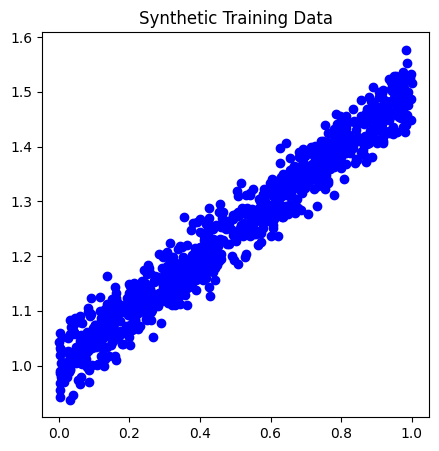

In [1]:
import torch
import matplotlib.pyplot as plt

# To ensure reproducibility
torch.manual_seed(42)

# Generating synthetic data
X = torch.rand(1000, 1) # random numbers from a uniform distribution on the interval (0, 1)
w_true, b_true = 0.5, 1
noise = torch.randn(1000, 1) * 0.03
y = w_true * X + b_true + noise

# Plot synthetic data
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5,5))
ax.scatter(X, y, color="b")
ax.set_title("Synthetic Training Data");

In [2]:
# Splitting into train/valid data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## Dataset

Full Reference: https://pytorch.org/docs/stable/data.html

In PyTorch, a **dataset** is represented by a regular Python class that inherits from the `Dataset` class

The most fundamental methods it needs to impliemnt are

*   `__init__(self)`: The constructor method takes the argument needed to build a list of tuples. Note that there is no need to load the whole dataset in the construtor method. If the dataset is large, loading it all at one would not be memory efficient. It is recommeded to load them on demand (whenever `__getitem__()` is called. It's typically used to store some essential locations like file paths and image transforms.

*   `__getitem__(self, idx)`: This method allow the dataset to be indexed so that it can work like a list **(dataset[idx])**. This should return a single data sample from athe dataset at a given index. The `__getitem__` method is where the actual dataloading and the preprocessing takes place. It takes an index as input and returns a data point, whcih can be a tensor or a ditionary of tensors. This method is used by `DataLoader` class to load and preprocess the data.

* `__len__(self)`: This shoudl return the size of the whole dataset. The indexing is limited to the actual size.

Below shows the sameple of creating **Custom Dataset** for our simple Linear regression data.



In [3]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = CustomDataset(X_train, y_train)
valid_data = CustomDataset(X_valid, y_valid)

In [4]:
print(train_data[0])

(tensor([0.3762]), tensor([1.2479]))


## TensorDataset

For our small Dataset, we can just simply use `TensorDataset` class to create a dataset.

In [5]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(X_valid, y_valid)
valid_data = TensorDataset(X_valid, y_valid)
print(train_data[0])

(tensor([0.9417]), tensor([1.4833]))


## DataLoader

While it is ok to use the whole training data for a small data set to perform **batch gradient descent**, computation and memory will become an issue for big dataset and **mini-batch gradient descent**.

**DataLoader** class to let our **Dataset** behave like an iterator by desciding on the **mini-batch-size** and to **shuffle** our Dataset during our training.

There are a few important parameters to note when setting up the DataLoader:

*   `shuffle`

    Note that for the majority of cases except Time Series problem, we shoudl set `shuffle=True` for our trainiing set to improve the performance of gradient descent. There is no need ot shuffle validation set given we are are not computing gradient with it.

    It is also possible to use it together with a **sampler** to fetch mini-batches that compensate for imablanced classes

*   `batch_size`

    It is typical to use powers of 2 for mini-batch sizes, like 16, 32, 64 or 128. and 32 seems to be the choice for most people. The main consideration for `batch_size` is the GPU memory

*   `drop_last`

    set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

*   `pin_memory`

     If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them. If your data elements are a custom type, or your collate_fn returns a batch that is a custom type, see the example below.

*   `num_workers`

    how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)


In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True,
    drop_last=True
)

valid_dataloader = DataLoader(
    dataset=valid_data,
    batch_size=16,
    shuffle=False,
    drop_last=True
)

below command can help to retreive a mini-batch

In [28]:
next(iter(train_dataloader))

[tensor([[0.9155],
         [0.9497],
         [0.0293],
         [0.2457],
         [0.2494],
         [0.7628],
         [0.7992],
         [0.5797],
         [0.4481],
         [0.0594],
         [0.5730],
         [0.2808],
         [0.6578],
         [0.4761],
         [0.8253],
         [0.7099]]),
 tensor([[1.4979],
         [1.5295],
         [1.0096],
         [1.1194],
         [1.0836],
         [1.4252],
         [1.3608],
         [1.3139],
         [1.1839],
         [0.9660],
         [1.2702],
         [1.1087],
         [1.3248],
         [1.2632],
         [1.3878],
         [1.3422]])]

## Defining the main `Learner` class

**The Constructor**

The constructor defines the attributes/arguments that make up the class. For the basic model training, we need to define 4 arguments:
*   model
*   loss
*   optimizer
*   data

While conceptually data is not part of the model, it is the input that we need ot use to train the model and should be included as an argument. We will initialised with None and add a method `set_loader` that can be used to supply the data (or even swap the dataset) at a later time.

In the constructor, we also initialise below:
*   **placeholders** for objects that are not available at the moment of creation
*   **variables** that we may want to keep track

\

**Train Method**

In the `train()` method, we need to add the **epoch-loop** where we set the training to go through a specified number of epochs (an input to the method). Moreoer, we also added the saving of results under `results` dictionary inside the `Learner` class

\

**Train loop and Valid Loop**

Inside the `train()` method, we define both `_train_loop()` and `_valid_loop()` which are both protected method indicated by the "_" in front of the name. The main intention for the train loop is to perform gradient descent. Note that the batch data is set to GPU inside each **mini-batch-loop**.

\

**Train Step and Valid Step**

This is the actual **Step** taken the calculate the loss. The reason for seperating this **Step** out is to ensure flexibility for different models. Note that we can subclass `Learner` class to override the `train_step()` and `valid_step()` method for more complex **step**

Below shows the main construction of our `Learner` Class

In [41]:
class Learner:
    def __init__(self, model, loss_fn, train_dataloader, valid_dataloader):
        # define attributes for learner class including model, loss_fn, optimizer and train_dl
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = self.configure_optimizer()
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader

        # Set attributes that are going to be computed internally
        self.total_epochs = 0
        self.batch = None
        self.loss = None    # loss from train/valid step
        self.train_loss = None  # intermediate aggregate/avg train_loss during _train_loop
        self.valid_loss = None  # intermediate aggregate/avg valid_loss during _valid_loop
        self.results = {
            'train_loss': [],
            'valid_loss': []
        }
        # Setting up device agnostic code
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # send model to GPU if available
        self.model.to(self.device)

    def configure_optimizer(self):
        return torch.optim.SGD(params=self.model.parameters(),
                               lr=0.1)

    def train(self, epochs):
        # perform train on specified number of epochs
        for epoch in range(epochs):
            # increment total_epochs
            self.total_epochs += 1
            # perform train_loop and valid_loop
            self._train_loop()
            self._valid_loop()
            self.results['train_loss'].append(self.train_loss)
            self.results['valid_loss'].append(self.valid_loss)
            print(f'Epoch: {epoch} | Train Loss: {self.train_loss:.3f} | Valid Loss: {self.valid_loss:.3f}')

    def _train_loop(self):
        # put model into train mode - default state of model
        self.model.train()
        # initialise train_loss to 0
        self.train_loss = 0
        # Perform the PyTorch train Loop with gradient descent
        for batch_num, batch in enumerate(self.train_dataloader):
            # Send batch to GPU if available
            self.batch = [tensor.to(self.device) for tensor in batch]
            # train_step to perform forward pass to return loss
            self.loss = self.train_step()
            # aggregate train_loss
            self.train_loss += self.loss.item()
            # gradient descent using optimizer
            self.loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        # take the average by dividing the aggregate train_loss to batch_num
        self.train_loss /= len(self.train_dataloader)

    def _valid_loop(self):
        # put model into eval mode
        self.model.eval()
        # initialise valid_loss to 0
        self.valid_loss = 0
        # use torch.inference_mode as a context manager
        # turns off gradient tracking which is not needed for validation
        with torch.inference_mode():
            for batch_num, batch in enumerate(self.valid_dataloader):
                # Send batch to GPU if available
                self.batch = [tensor.to(self.device) for tensor in batch]
                self.loss = self.valid_step()
                self.valid_loss += self.loss.item()
            self.valid_loss /= len(self.valid_dataloader)

    def train_step(self):
        X, y = self.batch
        y_logits = self.model(X)
        loss = self.loss_fn(y_logits, y)
        return loss

    def valid_step(self):
        X, y = self.batch
        y_logits = self.model(X)
        loss = self.loss_fn(y_logits, y)
        return loss


## Defining the Model

We will define a simple Linear Model using `nn.Linear()`

In [31]:
import torch.nn as nn

class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=True)
    def forward(self, X):
        return self.linear(X)

## Loss

MSE Loss using `nn.MSELoss()

In [32]:
loss_fn = nn.MSELoss(reduction='mean')
loss_fn

MSELoss()

## Optimizer

We will use simple SGD Optimizer for our problem

## Putting it all together with the `Learner` class

In [42]:
learner = Learner(model=LinearRegression(),
                  loss_fn=nn.MSELoss(reduction='mean'),
                  train_dataloader=train_dataloader,
                  valid_dataloader=valid_dataloader)

In [43]:
learner.train(5)

Epoch: 0 | Train Loss: 0.112 | Valid Loss: 0.002
Epoch: 1 | Train Loss: 0.002 | Valid Loss: 0.001
Epoch: 2 | Train Loss: 0.001 | Valid Loss: 0.001
Epoch: 3 | Train Loss: 0.001 | Valid Loss: 0.001
Epoch: 4 | Train Loss: 0.001 | Valid Loss: 0.001


In [45]:
learner.model.state_dict()

OrderedDict([('linear.weight', tensor([[0.5512]], device='cuda:0')),
             ('linear.bias', tensor([0.9703], device='cuda:0'))])

## Installing `sstorch` package through pip

We will use `sstorch` package to continue our development for minimizing the boilerplate code for PyTorch Code. Note that `sstorch` also has other functions that is useful for PyTorch training that will be documented under sstorch reference session in the ssnote

In [46]:
# Installing sstorch package
!pip -q install git+https://github.com/ronald-hk-chung/sstorch.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 19.4 MB/s eta 0:00:00


In [63]:
from sstorch.learner import SSTLearner

class LinearLearner(SSTLearner):
    def __init__(self):
        super().__init__(model=LinearRegression(),
                         loss_fn=nn.MSELoss(),
                         train_dataloader=train_dataloader,
                         valid_dataloader=valid_dataloader)

    def configure_optimizer(self):
        return torch.optim.SGD(params=self.model.parameters(), lr=0.1)

    def train_step(self):
        X, y = self.batch
        y_logits = self.model(X)
        loss = self.loss_fn(y_logits, y)
        return loss, 0

    def valid_step(self):
        X, y = self.batch
        y_logits = self.model(X)
        loss = self.loss_fn(y_logits, y)
        return loss, 0

In [64]:
learner = LinearLearner()

In [65]:
learner.train(10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-01 | train_loss: 0.211 | valid_loss: 0.012 
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-01 | train_loss: 0.01 | valid_loss: 0.009 
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-01 | train_loss: 0.007 | valid_loss: 0.006 
----------------------------------------------------------------------------------------------------
Epoch: 4 | LR: 1.0E-01 | train_loss: 0.006 | valid_loss: 0.005 
----------------------------------------------------------------------------------------------------
Epoch: 5 | LR: 1.0E-01 | train_loss: 0.004 | valid_loss: 0.004 
----------------------------------------------------------------------------------------------------
Epoch: 6 | LR: 1.0E-01 | train_loss: 0.003 | valid_loss: 0.003 
----------------------------------------------------------------------------------------------------
Epoch: 7 | 

In [66]:
learner.model.state_dict()

OrderedDict([('linear.weight', tensor([[0.5913]], device='cuda:0')),
             ('linear.bias', tensor([0.9516], device='cuda:0'))])

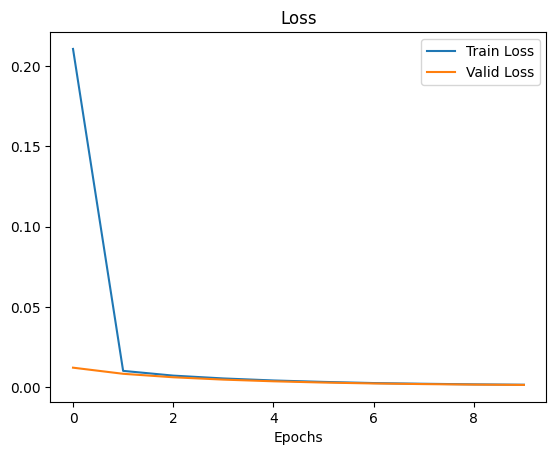

In [67]:
learner.plot_loss_curve()